In [1]:
CUDA_LAUNCH_BLOCKING=1
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import os
import os.path
from os.path import normpath, basename
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from typing import List, Union, Tuple, Any
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import shutil
import sys

In [2]:
'''MobilenetV2 in PyTorch.
See the paper "MobileNetV2: Inverted Residuals and Linear Bottlenecks" for more details.
'''
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv3d(inp, oup, kernel_size=3, stride=stride, padding=(1,1,1), bias=False),
        nn.BatchNorm3d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv3d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm3d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == (1,1,1) and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv3d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm3d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv3d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm3d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv3d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm3d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv3d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm3d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv3d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm3d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, sample_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1,  16, 1, (1,1,1)],
            [6,  24, 2, (2,2,2)],
            [6,  32, 3, (2,2,2)],
            [6,  64, 4, (2,2,2)],
            [6,  96, 3, (1,1,1)],
            [6, 160, 3, (2,2,2)],
            [6, 320, 1, (1,1,1)],
        ]

        # building first layer
        assert sample_size % 16 == 0.
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, (1,2,2))]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else (1,1,1)
                self.features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = F.avg_pool3d(x, x.data.size()[-3:])
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [3]:
class ImglistToTensor(torch.nn.Module):
    """
    Converts a list of PIL images in the range [0,255] to a torch.FloatTensor
    of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1].
    Can be used as first transform for ``VideoFrameDataset``.
    """
    @staticmethod
    def forward(img_list: List[Image.Image]) -> 'torch.Tensor[NUM_IMAGES, CHANNELS, HEIGHT, WIDTH]':
        """
        Converts each PIL image in a list to
        a torch Tensor and stacks them into
        a single tensor.

        Args:
            img_list: list of PIL images.
        Returns:
            tensor of size ``NUM_IMAGES x CHANNELS x HEIGHT x WIDTH``
            
        
        """
        # print(type(img_list))
        # print(img_list)
        # print(np.array(img_list).shape)
        return torch.stack([transforms.functional.to_tensor(pic) for pic in img_list])
        # return torch.stack([transforms.functional.to_tensor(img_list)])

In [4]:
class VideoRecord(object):
    """
    Helper class for class VideoFrameDataset. This class
    represents a video sample's metadata.

    Args:
        root_datapath: the system path to the root folder
                       of the videos.
        row: A list with four or more elements where 1) The first
             element is the path to the video sample's frames excluding
             the root_datapath prefix 2) The  second element is the starting frame id of the video
             3) The third element is the inclusive ending frame id of the video
             4) The fourth element is the label index.
             5) any following elements are labels in the case of multi-label classification
    """
    def __init__(self, row, root_datapath):
        self._data = row
        self._path = os.path.join(root_datapath, row[0])


    @property
    def path(self) -> str:
        return self._path

    @property
    def num_frames(self) -> int:
        return self.end_frame - self.start_frame + 1  # +1 because end frame is inclusive
    @property
    def start_frame(self) -> int:
        return int(self._data[1])

    @property
    def end_frame(self) -> int:
        return int(self._data[2])

    @property
    def label(self) -> Union[int, List[int]]:
        # just one label_id
        if len(self._data) == 4:
            return int(self._data[3])
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._data[3:]]

In [5]:
class VideoFrameDataset(torch.utils.data.Dataset):
    r"""
    A highly efficient and adaptable dataset class for videos.
    Instead of loading every frame of a video,
    loads x RGB frames of a video (sparse temporal sampling) and evenly
    chooses those frames from start to end of the video, returning
    a list of x PIL images or ``FRAMES x CHANNELS x HEIGHT x WIDTH``
    tensors where FRAMES=x if the ``ImglistToTensor()``
    transform is used.

    More specifically, the frame range [START_FRAME, END_FRAME] is divided into NUM_SEGMENTS
    segments and FRAMES_PER_SEGMENT consecutive frames are taken from each segment.

    Note:
        A demonstration of using this class can be seen
        in ``demo.py``
        https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch

    Note:
        This dataset broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.


    Note:
        This class relies on receiving video data in a structure where
        inside a ``ROOT_DATA`` folder, each video lies in its own folder,
        where each video folder contains the frames of the video as
        individual files with a naming convention such as
        img_001.jpg ... img_059.jpg.
        For enumeration and annotations, this class expects to receive
        the path to a .txt file where each video sample has a row with four
        (or more in the case of multi-label, see README on Github)
        space separated values:
        ``VIDEO_FOLDER_PATH     START_FRAME      END_FRAME      LABEL_INDEX``.
        ``VIDEO_FOLDER_PATH`` is expected to be the path of a video folder
        excluding the ``ROOT_DATA`` prefix. For example, ``ROOT_DATA`` might
        be ``home\data\datasetxyz\videos\``, inside of which a ``VIDEO_FOLDER_PATH``
        might be ``jumping\0052\`` or ``sample1\`` or ``00053\``.

    Args:
        root_path: The root path in which video folders lie.
                   this is ROOT_DATA from the description above.
        annotationfile_path: The .txt annotation file containing
                             one row per video sample as described above.
        num_segments: The number of segments the video should
                      be divided into to sample frames from.
        frames_per_segment: The number of frames that should
                            be loaded per segment. For each segment's
                            frame-range, a random start index or the
                            center is chosen, from which frames_per_segment
                            consecutive frames are loaded.
        imagefile_template: The image filename template that video frame files
                            have inside of their video folders as described above.
        transform: Transform pipeline that receives a list of PIL images/frames.
        test_mode: If True, frames are taken from the center of each
                   segment, instead of a random location in each segment.

    """
    def __init__(self,
                 root_path: str,
                 annotationfile_path: str,
                 num_segments: int = 3,
                 frames_per_segment: int = 1,
                 imagefile_template: str='img_{:05d}.jpg',
                 transform = None,
                 test_mode: bool = False):
        super(VideoFrameDataset, self).__init__()

        self.root_path = root_path
        self.annotationfile_path = annotationfile_path
        self.num_segments = num_segments
        self.frames_per_segment = frames_per_segment
        self.imagefile_template = imagefile_template
        self.transform = transform
        self.test_mode = test_mode

        self._parse_annotationfile()
        self._sanity_check_samples()

    def _load_image(self, directory: str, idx: int) -> Image.Image:
        return Image.open(os.path.join(directory, self.imagefile_template.format(idx))).convert('RGB')

    def _parse_annotationfile(self):
        self.video_list = [VideoRecord(x.strip().split(), self.root_path) for x in open(self.annotationfile_path)]

    def _sanity_check_samples(self):
        for record in self.video_list:
            if record.num_frames <= 0 or record.start_frame == record.end_frame:
                print(f"\nDataset Warning: video {record.path} seems to have zero RGB frames on disk!\n")

            elif record.num_frames < (self.num_segments * self.frames_per_segment):
                print(f"\nDataset Warning: video {record.path} has {record.num_frames} frames "
                      f"but the dataloader is set up to load "
                      f"(num_segments={self.num_segments})*(frames_per_segment={self.frames_per_segment})"
                      f"={self.num_segments * self.frames_per_segment} frames. Dataloader will throw an "
                      f"error when trying to load this video.\n")

    def _get_start_indices(self, record: VideoRecord) -> 'np.ndarray[int]':
        """
        For each segment, choose a start index from where frames
        are to be loaded from.

        Args:
            record: VideoRecord denoting a video sample.
        Returns:
            List of indices of where the frames of each
            segment are to be loaded from.
        """
        # choose start indices that are perfectly evenly spread across the video frames.
        if self.test_mode:
            distance_between_indices = (record.num_frames - self.frames_per_segment + 1) / float(self.num_segments)

            start_indices = np.array([int(distance_between_indices / 2.0 + distance_between_indices * x)
                                      for x in range(self.num_segments)])
        # randomly sample start indices that are approximately evenly spread across the video frames.
        else:
            max_valid_start_index = (record.num_frames - self.frames_per_segment + 1) // self.num_segments

            start_indices = np.multiply(list(range(self.num_segments)), max_valid_start_index) + \
                      np.random.randint(max_valid_start_index, size=self.num_segments)

        return start_indices

    def __getitem__(self, idx: int) -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        For video with id idx, loads self.NUM_SEGMENTS * self.FRAMES_PER_SEGMENT
        frames from evenly chosen locations across the video.

        Args:
            idx: Video sample index.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """
        record: VideoRecord = self.video_list[idx]

        frame_start_indices: 'np.ndarray[int]' = self._get_start_indices(record)

        return self._get(record, frame_start_indices)

    def _get(self, record: VideoRecord, frame_start_indices: 'np.ndarray[int]') -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        Loads the frames of a video at the corresponding
        indices.

        Args:
            record: VideoRecord denoting a video sample.
            frame_start_indices: Indices from which to load consecutive frames from.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """

        frame_start_indices = frame_start_indices + record.start_frame
        images = list()

        # from each start_index, load self.frames_per_segment
        # consecutive frames
        for start_index in frame_start_indices:
            frame_index = int(start_index)

            # load self.frames_per_segment consecutive frames
            for _ in range(self.frames_per_segment):
                image = self._load_image(record.path, frame_index)
                images.append(image)

                if frame_index < record.end_frame:
                    frame_index += 1

        if self.transform is not None:
            images = self.transform(images)

        return images, record.label

    def __len__(self):
        return len(self.video_list)

In [6]:
def eval_preprocess(size):
    preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(size),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(size),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ShiftWithChannelTensor()
    ])
    return preprocess

[INFO   ] [Logger      ] Record log in C:\Users\dlrdu\.kivy\logs\kivy_22-06-12_12.txt
[INFO   ] [deps        ] Successfully imported "kivy_deps.angle" 0.3.2
[INFO   ] [deps        ] Successfully imported "kivy_deps.glew" 0.3.1
[INFO   ] [deps        ] Successfully imported "kivy_deps.sdl2" 0.4.5
[INFO   ] [Kivy        ] v2.1.0
[INFO   ] [Kivy        ] Installed at "C:\ProgramData\Anaconda3\envs\python_v\lib\site-packages\kivy\__init__.py"
[INFO   ] [Python      ] v3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
[INFO   ] [Python      ] Interpreter at "C:\ProgramData\Anaconda3\envs\python_v\python.exe"
[INFO   ] [Logger      ] Purge log fired. Processing...
[INFO   ] [Logger      ] Skipped file C:\Users\dlrdu\.kivy\logs\kivy_22-06-06_17.txt, PermissionError(13, '다른 프로세스가 파일을 사용 중이기 때문에 프로세스가 액세스 할 수 없습니다')
[INFO   ] [Logger      ] Purge finished!
[INFO   ] [Factory     ] 189 symbols loaded
[INFO   ] [Image       ] Providers: img_tex, img_dds, img_sdl2, img_pil (img_ff

background animated
card animated
str_datetime 2022-06-12
daily_time 1740
study_screen added
Screen [study_screen] added
background animated
dataset 폴더 안 영상 삭제
dataset 폴더 안 영상 삭제
dataset 폴더 안 영상 삭제
분석시작
captured_num 1 영상 분석 -->  data/dataset/video_0001.mp4
path data subdirs ['.ipynb_checkpoints', 'dataset'] files []
path data\.ipynb_checkpoints subdirs [] files []
path data\dataset subdirs [] files ['video_0001.mp4', 'video_0002.mp4']
files[captured_num-2] video_0001.mp4
Currently have 1 video data...
y_pred [3]
행동 -->  using_computer
30 행동 15초 추가
study_time 15
분석종료 analysis_num 0
분석시작
captured_num 2 영상 분석 -->  data/dataset/video_0002.mp4
path data subdirs ['.ipynb_checkpoints', 'dataset'] files []
path data\.ipynb_checkpoints subdirs [] files []
path data\dataset subdirs [] files ['video_0001.mp4', 'video_0002.mp4', 'video_0003.mp4']
files[captured_num-2] video_0002.mp4
Currently have 1 video data...
y_pred [5]
행동 -->  writing
30 행동 15초 추가
study_time 30
분석종료 analysis_num 0
분석시작
captur

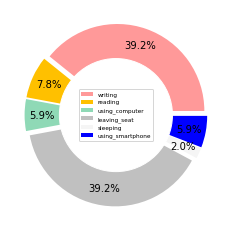

background animated
background animated
Screen [registration_screen] already exists


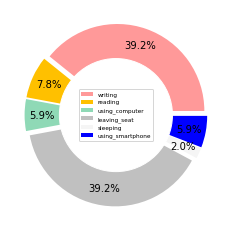

background animated
background animated


In [ ]:
import traceback
from kivy.app import App
from kivy.core.window import Window
from kivy.lang import Builder
from kivy.uix.screenmanager import Screen, ScreenManager
from kivy.factory import Factory
from kivy.animation import Animation
from kivy.uix.boxlayout import BoxLayout
from kivy.properties import ListProperty
from kivy.metrics import dp
from kivy.uix.button import Button
from kivy.uix.behaviors import ButtonBehavior
from kivymd.uix.behaviors import CircularRippleBehavior
from kivymd.toast.kivytoast.kivytoast import toast
from kivy.core.audio import SoundLoader

from kivymd.app import MDApp
from kivymd.uix.bottomnavigation import MDBottomNavigationItem
from kivymd.uix.card import MDCard

from tkinter import messagebox as msg
from tkinter import Tk

import matplotlib.pyplot as plt
from kivy.uix.floatlayout import FloatLayout
from kivy.garden.matplotlib.backend_kivyagg import FigureCanvasKivyAgg
from kivy.uix.image import Image
from PIL import Image

from kivy.config import Config
Config.set('graphics', 'fullscreen','0')

import csv
from datetime import datetime


Window.softinput_mode = "below_target"  # resize to accomodate keyboard
Window.keyboard_anim_args = {'d': 0.5, 't': 'in_out_quart'}

Builder.load_string("""
#:import utils kivy.utils
#:include kv/login.kv
""")


class JobListScreen(Screen):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def on_enter(self):
        for _ in range(10):
            MDApp.get_running_app().job_list.append({"height": dp(150)})


class JobListCard(MDCard):
    def prepare_viewing_of_publication(self):
        print(int(self.publication_id))
    def view_job(self, job_card):
        print(job_card)
    
    def toggle_heart(self, widget):
        if widget.icon == "heart":
            widget.icon = "heart-outline" if widget.icon == "heart" else "heart-outline"
            toast("Job unsaved")
        else:
            widget.icon = "heart" if widget.icon == "heart-outline" else "heart"
            toast("Job saved")


class HomeScreen(Screen):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def on_enter(self):
        MDApp.get_running_app().category_list.append({"height": dp(150)})
        MDApp.get_running_app().category_list.append({"height": dp(150)})
        MDApp.get_running_app().category_list.append({"height": dp(150)})
        MDApp.get_running_app().category_list.append({"height": dp(150)})
        MDApp.get_running_app().category_list.append({"height": dp(150)})

class CategoryCard(MDCard,CircularRippleBehavior, ButtonBehavior):
    def open_category(self, widget):
        print(widget)
    def on_release(self):
        MDApp.get_running_app().manage_screens("job_list_screen", "add")
        MDApp.get_running_app().change_screen("job_list_screen")

class Emp(MDApp):
    job_list = ListProperty() # contains data needed to display job list cards
    category_list = ListProperty() # contains data needed to display job list cards
    global study_time
    global notstudy_time
    global writing
    global reading
    global using_computer
    global leaving_seat
    global sleeping
    global using_smartphone
    #global graph_1
    #graph_1 = MDApp.get_running_app().get_screen('registration_screen')  
    
    writing = 15
    reading = 15
    using_computer = 15
    leaving_seat = 15
    sleeping = 15
    using_smartphone = 15
    study_time = 0
    notstudy_time = 0
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.title = "Fourstars Study"
        self.theme_cls.primary_palette = "DeepPurple"
        self.theme_cls.theme_style = "Light"
        self.sm = ScreenManager()
        self.has_animated_card = False
        self.has_animated_background = False
    
    def account_action(self, email, passwd, username=None, action=None):
        print(email, passwd, username, action)
        if action == "register":
            pass
            # register the user
        elif action == "login":
            # login the user
            pass
        self.manage_screens("home_screen", "add")
        self.change_screen("home_screen")

    def animate_background(self, widget):
        if self.has_animated_background == False:
            anim = Animation(size_hint_y=1) + Animation(size_hint_y=0.5)
            anim.start(widget.ids.bx)
            print("background animated")
        else:
            print("background already animated")
    
    def animate_card(self, widget):
        # {"center_x": 0.5, "center_y": 0.6}
        if self.has_animated_card == False:
            anim = Animation(pos_hint={"center_x": 0.5, "center_y": 0.6}, duration=2)
            anim.start(widget)
            self.has_animated_card = True
            print("card animated")
        else:
            print("card already animated")

    def change_screen(self, screen_name):
        if self.sm.has_screen(screen_name):
            self.sm.current = screen_name
        else:
            print("Screen [" + screen_name + "] does not exist.")

    def manage_screens(self, screen_name, action):
        scns = {
            "study_screen": Factory.StudyScreen,
            "login_screen": Factory.LoginScreen,
            "registration_screen": Factory.RegistrationScreen,
            "home_screen": Factory.HomeScreen,
            "job_list_screen": Factory.JobListScreen
        }
        try:

            if action == "remove":
                if self.sm.has_screen(screen_name):
                    self.sm.remove_widget(self.sm.get_screen(screen_name))
                print("Screen ["+screen_name+"] removed")
            elif action == "add":
                if self.sm.has_screen(screen_name):
                    print("Screen [" + screen_name + "] already exists")
                else:
                    self.sm.add_widget(scns[screen_name](name=screen_name))
                    print(screen_name + " added")
                    print("Screen ["+screen_name+"] added")
        except:
            print(traceback.format_exc())
            print("Traceback ^.^")

    def on_pause(self):
        return True

    def on_resume(self):
        pass
    
    def update(self):
        global study_time
        global notstudy_time
        #분석전 test폴더 있으면 삭제한다
        if os.path.exists(r"./data/test") == True :
            print('test 폴더 삭제')
            shutil.rmtree("./data/test")
        #분석전 dataset폴더 안에 저장된 영상 있으면 삭제한다    
        for file in os.scandir('./data/dataset'):
            os.remove(file.path)
            print('dataset 폴더 안 영상 삭제')
    
        cap = cv2.VideoCapture(0)
        
        if not cap.isOpened():
            print("Camera open failed!")
            sys.exit()
            
        w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS) # 카메라에 따라 값이 정상적, 비정상적
        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        delay = round(1000/fps)
        
        captured_num=1
        analysis_num=0
        alarm_notstudy = 0
        out = cv2.VideoWriter('data/dataset/video_{:04d}.mp4'.format(captured_num), fourcc, fps, (w, h))
        
        if not out.isOpened():
            print('File open failed!')
            cap.release()
            sys.exit()
            
        sample_num = 0
        record = False
        
        while True:                 # 무한 루프
            ret, frame = cap.read() # 카메라의 ret, frame 값 받아오기
            sample_num = sample_num + 1

            if not ret:             #ret이 False면 중지
                break

            cv2.imshow('frame', frame)
            
            if analysis_num == 1:
                print('분석시작')
                
                print('captured_num',captured_num-1,'영상 분석 --> ','data/dataset/video_{:04d}.mp4'.format(captured_num-1))
                
                v_l = cv2.VideoCapture('data/dataset/video_{:04d}.mp4'.format(captured_num-1))

                if not v_l.isOpened():
                    print("could not open :", 'data/dataset/video_{:04d}.mp4'.format(captured_num-1))
                    exit(0)

                length = int(v_l.get(cv2.CAP_PROP_FRAME_COUNT))
                # print('video length',length)

                if length > 90:
                    def check_mkdir(dir_name):
                        if not os.path.exists(dir_name):
                            os.mkdir(dir_name)

                    def create_frames_from_video(video_location, save_folder ,name_prefix='img', extension='jpg'):
                        # Read the video from specified path
                        cam = cv2.VideoCapture(video_location)
                        currentframe = 1
                        while(True):
                            # reading from frame
                            ret,frame = cam.read()
                            if ret:
                                # if video is still left continue creating images
                                name= os.path.join(save_folder, f'{name_prefix}_{currentframe:05d}.{extension}')

                                # writing the extracted images
                                cv2.imwrite(name, frame)

                                # increasing counter so that it will
                                # show how many frames are created
                                currentframe += 1
                            else:
                                break

                        cam.release()
                        cv2.destroyAllWindows()
                        return currentframe

                    def plot_video(rows, cols, frame_list, plot_width, plot_height, title: str):
                        fig = plt.figure(figsize=(plot_width, plot_height))
                        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                                         nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                                         axes_pad=0.3,  # pad between axes in inch.
                                         )

                        for index, (ax, im) in enumerate(zip(grid, frame_list)):
                            # Iterating over the grid returns the Axes.
                            ax.imshow(im)
                            ax.set_title(index)
                        plt.suptitle(title)
                        plt.show()

                    def denormalize(video_tensor):
                        """
                        Undoes mean/standard deviation normalization, zero to one scaling,
                        and channel rearrangement for a batch of images.
                        args:
                            video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
                        """
                        inverse_normalize = transforms.Normalize(
                            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
                        )
                        return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()

                    class ShiftWithChannelTensor:
                        def __call__(self, data):
                            return data.permute(1, 0, 2, 3).contiguous()

                        def __repr__(self):
                            return self.__class__.__name__ + '()'

                    DATA_PATH = 'data'
                    # create dictionary of activities

                    list_activities= os.listdir(DATA_PATH)
                    list_dict= {}
                    for index,activity in enumerate(list_activities):
                        list_dict[activity] = index

                    # create list of data
                    all_x =[]
                    all_y = []
                    for path, subdirs, files in os.walk(DATA_PATH):
                        print('path',path,'subdirs',subdirs,'files',files)
                        # for name in files:
                        #     all_x.append(os.path.join(path, name))
                        #     all_y.append(list_dict[basename(normpath(path))])
                    # print('captured_num',captured_num)
                    # print('files[captured_num - 2]',files[captured_num - 2])
                    
                    if len(files) > 3:
                        print('영상삭제',"./data/dataset/video_{:04d}.mp4".format(captured_num-3))
                        os.remove("./data/dataset/video_{:04d}.mp4".format(captured_num-3))
                        print('files',files)
                        
                    #여기서 에러나면 checkipynb폴더 생겼는지 확인하고 삭제해라
                    if captured_num < 5:
                        print('files[captured_num-2]',files[captured_num-2])
                        all_x.append(os.path.join(path, files[captured_num-2]))
                    else:
                        print('files[-2]',files[-2])
                        all_x.append(os.path.join(path, files[-2]))
                    all_y.append(list_dict[basename(normpath(path))])

                    print(f"Currently have {len(all_x)} video data...")  

                    # generate image for train & test
                    check_mkdir('data/test')

                    for key,value in list_dict.items():
                        check_mkdir(os.path.join('data/test',str(value)))

                    with open('data/test/annotations.txt', 'w') as f:
                        for index,video in enumerate(all_x):
                            vid_in_folder = len(os.listdir(os.path.join('data/test',str(all_y[index]))))
                            path_folder = os.path.join('data/test',str(all_y[index]),str(vid_in_folder+1).zfill(5))
                            check_mkdir(path_folder)
                            # parse video into frame
                            last_frame = create_frames_from_video(video,path_folder)
                            # create note
                            f.write(f'{all_y[index]}/{str(vid_in_folder+1).zfill(5)} 1 {last_frame-1} {all_y[index]}')
                            f.write('\n')

                    def eval_preprocess(size):
                        preprocess = transforms.Compose([
                            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
                            transforms.Resize(size),  # image batch, resize smaller edge to 299
                            transforms.CenterCrop(size),  # image batch, center crop to square 299x299
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            ShiftWithChannelTensor()
                        ])
                        return preprocess

                    n_epochs= 80
                    train_on_gpu = False
                    size = 112

                    eval_preprocess = eval_preprocess(size)

                    test_dataset = VideoFrameDataset(
                        root_path='data/test',
                        annotationfile_path='data/test/annotations.txt',
                        num_segments=1,
                        frames_per_segment=16,
                        imagefile_template='img_{:05d}.jpg',
                        transform=eval_preprocess,
                        test_mode=False
                    )

                    test_dataloader = torch.utils.data.DataLoader(
                        dataset=test_dataset,
                        batch_size=8,
                        shuffle=False,
                        num_workers=0,#2
                        pin_memory=True
                    )


                    # Load torch model
                    PATH = 'model/transfer_mobilenet.pt'
                    device = torch.device('cpu')
                    model = MobileNetV2(num_classes=6, sample_size=size, width_mult=1.)
                    model.load_state_dict(torch.load(PATH, map_location=device),strict=False)

                    '''PATH = 'model_state_dict.pt'
                    device = torch.device('cuda')
                    model = MobileNetV2(num_classes=6, sample_size=size, width_mult=1.0)
                    model.load_state_dict(torch.load(PATH),strict=False)
                    model.to(device)
                    '''
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=0.0001)
                    scheduler = ReduceLROnPlateau(optimizer, 'min',patience=10,verbose=True,min_lr=1e-10)

                    ######################    
                    # validate the model #
                    ######################
                    model.eval()
                    y_pred = np.array([],dtype='i')
                    y_truth = np.array([],dtype='i')
                    # print('validation')
                    for data, target in test_dataloader:
                        output = model(data)
                        # print('output', output)
                        y_pred = np.concatenate((y_pred, np.argmax(output.clone().detach().cpu().numpy(),axis=1)))
                    np.argmax(output.clone().detach().cpu().numpy(),axis=1)
                    print('y_pred',y_pred)
                    
                    ##폴더,분석한 영상 삭제
                    shutil.rmtree("./data/test")
                    
                    label_dict = {'leaving_seat': 0, 'reading': 1, 'sleeping': 2, 'using_computer': 3, 'using_smartphone': 4, 'writing': 5}
                    for key, value in label_dict.items():
                        if value == y_pred[0]:
                            activity_label = key
                    print('행동 --> ',activity_label)
                    
                    globals()['{}'.format(activity_label)]+=15
                    print(globals()['{}'.format(activity_label)],'행동 15초 추가')
                    
                    #공부시간 계산
                    if y_pred[0] in [1,3,5]:
                        study_time += 15
                        print('study_time',study_time)
                    else:
                        notstudy_time += 15
                        alarm_notstudy += 15
                        print('notstudy_time',notstudy_time)
                        
                    if alarm_notstudy >= 300:
                        sound = SoundLoader.load('kv/alarm.wav')
                        sound.play()
                        alarm_notstudy = 0
                    
                
                analysis_num = 0
                print('분석종료 analysis_num',analysis_num)
                

            if 100<=sample_num<=190:
                record = True

            if record == True:
                out.write(frame)

            if sample_num > 191:
                #record = False
                # print(sample_num)
                captured_num += 1
                analysis_num += 1
                # print('captured_num',captured_num)
                # print('analysis_num',analysis_num)
                
                record = False
                sample_num = 0
                out = cv2.VideoWriter('data/dataset/video_{:04d}.mp4'.format(captured_num), fourcc, fps, (w, h))
                
            if cv2.waitKey(delay) == 27: # esc를 누르면 강제 종료
                a = datetime.today()
                format = '%Y-%m-%d'
                str_datetime = datetime.strftime(a,format)
                print('str_datetime',str_datetime)

                print('최종집중시간',study_time)
                print('최종비집중시간',notstudy_time)
                
                with open('time.csv', 'r', encoding='UTF-8') as f:
                    reader = csv.reader(f)
                    station_info = list(reader)
                    for i in range(1,len(station_info)):
                        if station_info[i][0] == str_datetime :
                            station_info[i][1]=int(station_info[i][1])+int(study_time)

                with open('time.csv', 'w', encoding='UTF-8', newline='') as f:
                    wr = csv.writer(f)
                    for i in range(len(station_info)):
                        wr.writerow(station_info[i])
                
                f.close()
                break
                
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        
        return study_time, notstudy_time, writing, reading, using_computer, leaving_seat, sleeping, using_smartphone
    def get_date(self):
        a = datetime.today()
        format = '%Y-%m-%d'
        str_datetime = datetime.strftime(a,format)
        return str_datetime
    
    def get_study_result(self):
        global study_time
        hours = study_time // 3600
        study_time = study_time - hours*3600
        mu = study_time // 60
        ss = study_time - mu*60
        study_result = '{}h {}m {}s'.format(hours,mu,ss)
        return study_result
    
    def get_not_study_result(self):
        global notstudy_time
        hours = notstudy_time // 3600
        notstudy_time = notstudy_time - hours*3600
        mu = notstudy_time // 60
        ss = notstudy_time - mu*60
        notstudy_result = '{}h {}m {}s'.format(hours,mu,ss)
        return notstudy_result
    
    def get_daily_study_result(self):
        a = datetime.today()
        format = '%Y-%m-%d'
        str_datetime = datetime.strftime(a,format)
        print('str_datetime',str_datetime)
        
        with open('time.csv', 'r', encoding='UTF-8') as f:
            reader = csv.reader(f)
            station_info = list(reader)  
            for i in range(1,len(station_info)):
                if station_info[i][0] == str_datetime :
                    daily_time = station_info[i][1]
        print('daily_time',daily_time)
        hours = int(daily_time) // 3600
        daily_time = int(daily_time) - hours*3600
        mu = int(daily_time) // 60
        ss = int(daily_time) - mu*60
        daily_time = '{}h {}m {}s'.format(hours,mu,ss)

        return daily_time
    
    def get_weekly_study_result(self):
        week = datetime.now().isocalendar()[1]
        print('week',week)
        week_time = 0

        with open('time.csv', 'r', encoding='UTF-8') as f:
            reader = csv.reader(f)
            station_info = list(reader)
            for i in range(1,len(station_info)):
                wyear = int(station_info[1][0][0:4])
                wmonth = int(station_info[1][0][6])
                wday = int(station_info[1][0][8:10])
                date = datetime(wyear,wmonth,wday)
                iso_calendar = date.isocalendar()
                print('iso_calendar[1]',iso_calendar[1])
                if int(week) == 22:
                    week = 21
                print('week',week,type(week))
                if int(iso_calendar[1]) == int(week) :
                    try : 
                        week_time += int(station_info[i][1])
                        print('week_time',week_time)
                    except :
                        pass
        
        print('week_time',week_time)
        hours = int(week_time) // 3600
        week_time = int(week_time) - hours*3600
        mu = int(week_time) // 60
        ss = int(week_time) - mu*60
        week_time = '{}h {}m {}s'.format(hours,mu,ss)
        return week_time
    
    def get_monthly_study_result(self):
        month = int(datetime.today().month)
        month_time=0
        with open('time.csv', 'r', encoding='UTF-8') as f:
            reader = csv.reader(f)
            station_info = list(reader)
            for i in range(1,len(station_info)):
                if int(station_info[i][0][6]) == month :
                    try :
                        month_time += int(station_info[i][1])
                    except : 
                        pass
        print('month_time',month_time)
        hours = int(month_time) // 3600
        month_time = int(month_time) - hours*3600
        mu = int(month_time) // 60
        ss = int(month_time) - mu*60
        month_time = '{}h {}m {}s'.format(hours,mu,ss)
        return month_time
    
    def update_donut_graph(self):
        global writing, reading, using_computer, leaving_seat, sleeping, using_smartphone
        plt.clf()  # clear the plot
        #graph_1 = MDApp.get_running_app().root.get_screen('registration_screen')
        #graph_1.ids.expense_graph.clear_widgets()
        # create data
        labels = ['writing', 'reading', 'using_computer', 'leaving_seat','sleeping','using_smartphone']
        total = writing+reading+using_computer+leaving_seat+sleeping+using_smartphone
        data_values = [(writing/total)*100,(reading/total)*100,(using_computer/total)*100,(leaving_seat/total)*100,(sleeping/total)*100,(using_smartphone/total)*100]
        colors = ['#ff9999', '#ffc000', '#8fd9b6','silver', 'whitesmoke', 'blue']
        # Create a white circle for the center of the plot
        my_circle = plt.Circle((0, 0), 0.65, color='white')
        # Create graph, add and place percentage labels
        # Add spaces to separate elements from the donut
        explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
        plt.pie(data_values, autopct="%.1f%%", startangle=0, pctdistance=0.80, labeldistance=1.2, explode=explode, colors=colors)
        p = plt.gcf()
        p.gca().add_artist(my_circle)
        # Create and place legend of the graph
        plt.legend(labels=labels, loc="center", fontsize='xx-small')
        # Add graph to Kivy App
        # plt.show()
        # THE DESIRED RESULT IS TO ADD THE GRAPH TO THE APP WITH THE LINE OF CODE BELOW, INSTEAD OF THE plt.show() line
        #graph = self.ids.graph
        #graph.add_widget(FigureCanvasKivyAgg(figure=plt.gcf()))
        
        
        plt.savefig('graph.png',dpi=300)
        plt.show()

    def build(self):
        self.bind(on_start=self.post_build_init)
        self.sm.add_widget(Factory.LoginScreen())
        # self.sm.add_widget(HomeScreen(name="home_screen"))
        # self.sm.current = "login_screen"
        return self.sm

    def post_build_init(self, ev):
        win = self._app_window
        win.bind(on_keyboard=self._key_handler)

    def _key_handler(self, *args):
        key = args[1]
        # 1000 is "back" on Android
        # 27 is "escape" on computers
        if key in (1000, 27):
            try:
                self.sm.current_screen.dispatch("on_back_pressed")
            except Exception as e:
                print(e)
            return True
        elif key == 1001:
            try:
                self.sm.current_screen.dispatch("on_menu_pressed")
            except Exception as e:
                print(e)
            return True
        
    
if __name__ == "__main__":
    Emp().run()